In [58]:
import numpy as np
import pandas as pd
import tempfile
import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import pandapower.control as control
import matplotlib.pyplot as plt
%matplotlib inline 

In [59]:
def timeseries_example(net, output_dir):
    # 1. create (random) data source
    n_timesteps = 192
    profiles, ds = create_data_source(n_timesteps)
    # 2. create controllers 
    create_controllers(net, ds)
    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)
    # 3. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)
    return ow

In [60]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(110/20) b2----b3 load
                                    |
                                    |
                                    b4 sgen
    """
    net= pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 110)
    b1 = pp.create_bus(net, 110)
    b2 = pp.create_bus(net, 20)
    b3 = pp.create_bus(net, 20)
    b4 = pp.create_bus(net, 20)

    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0")
    pp.create_transformer(net, b1, b2, "25 MVA 110/20 kV", name='tr1')
    pp.create_line(net, b2, b3, 10, "184-AL1/30-ST1A 20.0")
    pp.create_line(net, b2, b4, 10, "184-AL1/30-ST1A 20.0")

    pp.create_load(net, b2, p_mw=20., q_mvar=10., name='load1')
    pp.create_sgen(net, b4, p_mw=20., q_mvar=0.15, name='sgen1')

    return net

In [61]:
#gen = pd.read_excel("actual_generation_renewables.xlsx",usecols=["Total_MWh"])
#ds1 = DFData(gen)
#load_steps = pd.read_excel("Load_Profile_H0_Summer.xlsx", usecols=["Load_MW"])

In [62]:
def create_data_source(n_timesteps=24):
    profiles = pd.DataFrame()
    profiles['load1_p'] = pd.read_excel("Load_Profile_H0_Summer_scaled_01.xlsx", usecols=["s_load"])
    profiles['sgen1_p'] = pd.read_excel("actual_generation_renewables_scaled_01.xlsx",usecols=["s_gen"])
   # profiles['c'] = 0.95 + np.random.random(n_timesteps) * (1.05-0.95)

    ds = DFData(profiles)
    
    # a + r*k
    # k = b-a
    # range between a and b within k

    return profiles, ds


# Load profile and Generation profile are scaled down to 20MW base

In [63]:
def create_controllers(net, ds):
   # c = control.ContinuousTapControl(net=net, tid=0, vm_set_pu=0.98, tol=1e-6)
    #ConstControl(net, element='controller', variable='object.vm_set_pu', element_index=c.index, data_source=ds, 
   #              profile_name='c')
    ConstControl(net, element='sgen', variable='p_mw', element_index=0, data_source=ds, profile_name='sgen1_p')
    ConstControl(net, element='load', variable='p_mw', element_index=0, data_source=ds, profile_name='load1_p')

In [64]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path='Lab_Session_5', output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_sgen', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    ow.log_variable('res_trafo', 'loading_percent')
    #ow.log_variable("trafo","tap_pos")
    return ow

In [65]:
net = simple_test_net()

ow = timeseries_example(net, None)
pp.timeseries.run_time_series.run_timeseries(net, time_steps=range(192))
#pp.timeseries.run_time_series.run_timeseries(net,time_steps=range(24),continue_on_divergence=True)

100%|██████████| 192/192 [00:00<00:00, 199.07it/s]


In [66]:
def plot_results(ow, variable, title):
    p= ow.output[variable]
    p.plot(label=variable)
    plt.xlabel("time step")
    plt.ylabel(variable)
    plt.title(title)
    plt.grid()
    plt.show()

In [67]:
#ax=net.controller.at[1,'object'].data_source.df['c'].plot(zorder=1, linestyle='--', label='Voltage setpoint (p.u.)')
#ow.output['res_bus.vm_pu'][net.trafo.at[0, 'lv_bus']].plot(ax=ax, zorder=0, label='Voltage at the controlled bus (p.u.)')
#ax.legend(loc='upper center')

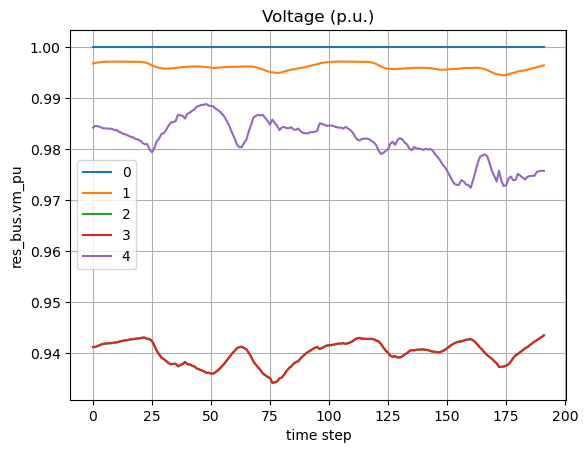

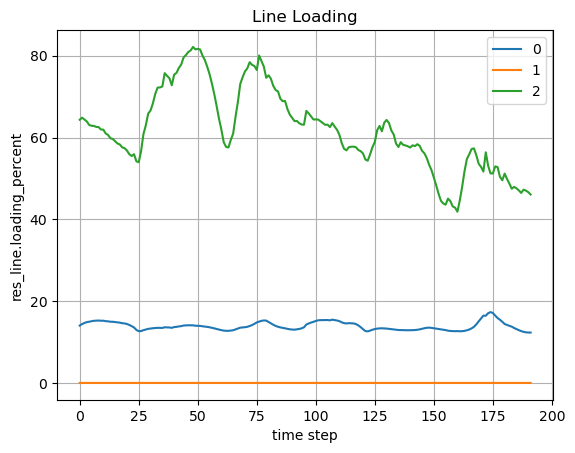

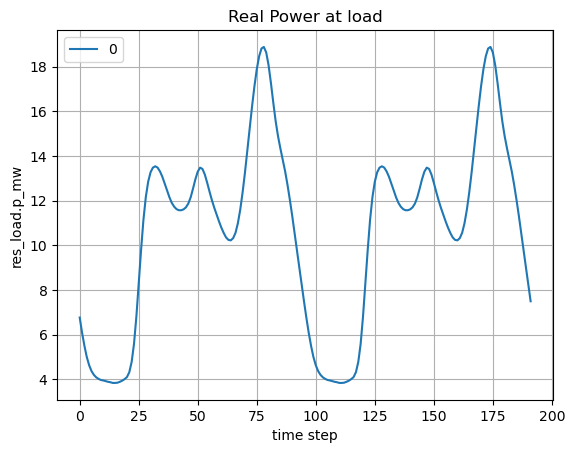

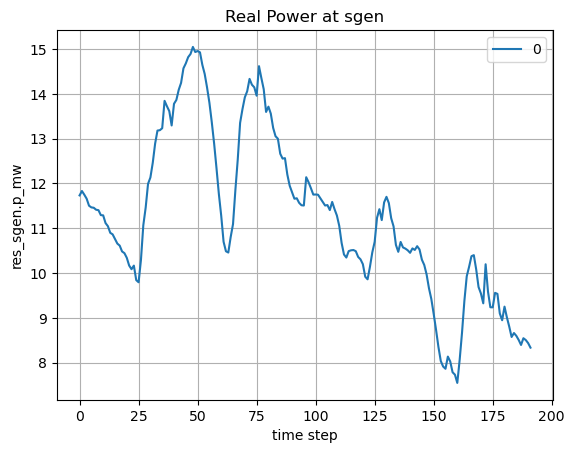

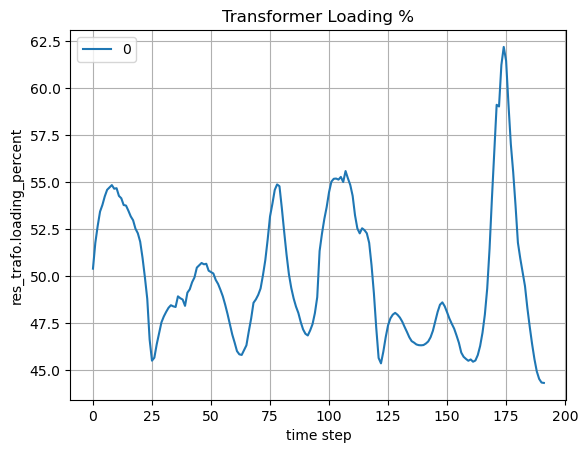

In [68]:
#plot_results(ow,"trafo.tap_pos","Tap Position")
plot_results(ow, 'res_bus.vm_pu', 'Voltage (p.u.)')
plot_results(ow, 'res_line.loading_percent', 'Line Loading')
plot_results(ow, 'res_load.p_mw', 'Real Power at load')
plot_results(ow, 'res_sgen.p_mw', 'Real Power at sgen')
plot_results(ow,'res_trafo.loading_percent', 'Transformer Loading %')

In [69]:
b1 = pd.read_excel("vm_pu_01.xlsx", usecols="B") #Bus_1 voltages
b2 = pd.read_excel("vm_pu_01.xlsx", usecols="C") #Bus_2 voltages
b3 = pd.read_excel("vm_pu_01.xlsx", usecols="D") #Bus_3 voltages
b4 = pd.read_excel("vm_pu_01.xlsx", usecols="E") #Bus_4 voltages
data = ((b1,b2,b3,b4))


{'whiskers': [<matplotlib.lines.Line2D at 0x222d6526eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x222d6524490>,
 'boxes': [<matplotlib.lines.Line2D at 0x222d6526c40>],
 'medians': [<matplotlib.lines.Line2D at 0x222d6524910>],
 'fliers': [<matplotlib.lines.Line2D at 0x222d6524be0>],
 'means': []}

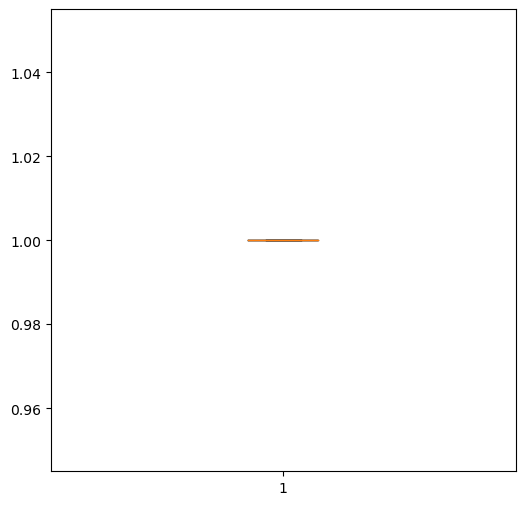

In [70]:
fig = plt.figure(figsize=(6,6))
plt.boxplot(b1)

{'whiskers': [<matplotlib.lines.Line2D at 0x222d4bfc490>,
 'caps': [<matplotlib.lines.Line2D at 0x222d4bfca60>,
 'boxes': [<matplotlib.lines.Line2D at 0x222d64f7040>],
 'medians': [<matplotlib.lines.Line2D at 0x222d4bda040>],
 'fliers': [<matplotlib.lines.Line2D at 0x222d4bda310>],
 'means': []}

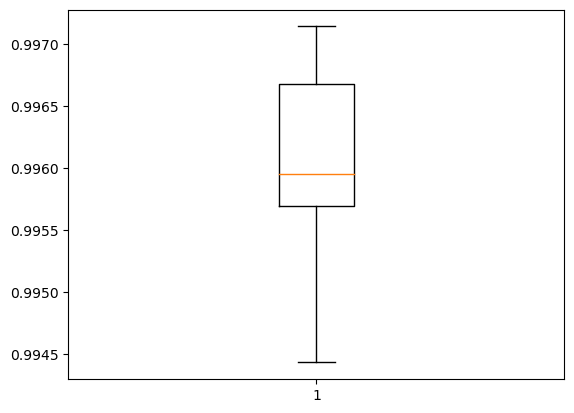

In [71]:
plt.boxplot(b2)


{'whiskers': [<matplotlib.lines.Line2D at 0x222d4278250>,
 'caps': [<matplotlib.lines.Line2D at 0x222d42785e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x222d42788e0>],
 'medians': [<matplotlib.lines.Line2D at 0x222d4278c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x222d427efa0>],
 'means': []}

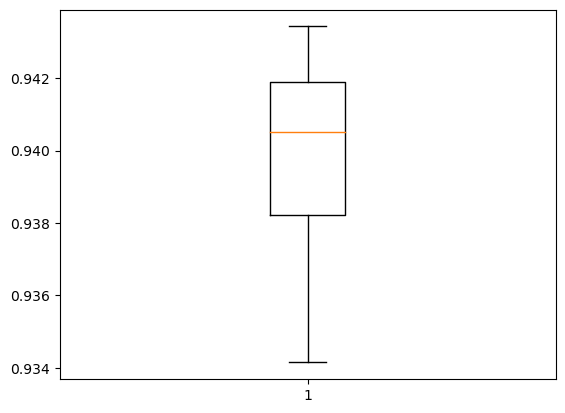

In [72]:
plt.boxplot(b3)

{'whiskers': [<matplotlib.lines.Line2D at 0x222d41d45e0>,
 'caps': [<matplotlib.lines.Line2D at 0x222d41d4c70>,
 'boxes': [<matplotlib.lines.Line2D at 0x222d41ea610>],
 'medians': [<matplotlib.lines.Line2D at 0x222d41d4af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x222d41d47f0>],
 'means': []}

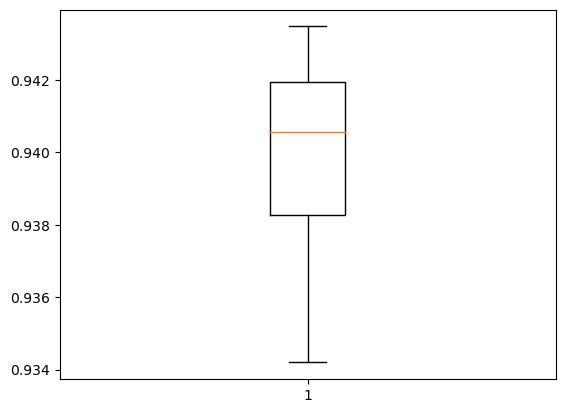

In [73]:
plt.boxplot(b4)